tl;dr Use only self-attention to classify MNIST.

No nn.Linear, no F.relu is allowed

96% accuracy in 5 epochs

**Scroll to bottom for results.**

# 1. Load libraries and dataset

In [1]:
# Training loader and training loop code is
# derived from https://github.com/floydhub/quick-start-pytorch/blob/master/mnist.ipynb
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

import random

SEED = 1
cuda = torch.cuda.is_available()
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True)# if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

Populating the interactive namespace from numpy and matplotlib


0it [00:00, ?it/s]

9920512it [00:02, 3958610.82it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 57992.66it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:01, 977767.53it/s]                             
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 22051.34it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# 2. Define model

In [2]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.mha1 = nn.MultiheadAttention(1, 1, dropout=0)
        self.mha2 = nn.MultiheadAttention(28, 1, dropout=0) 
        self.mha3 = nn.MultiheadAttention(784, 1, dropout=0) 
        self.mha4 = nn.MultiheadAttention(10, 1, dropout=0)
    def forward(self, x, ret_attn=False):
        # attention input dims length * bsz * embed_dim, lots of transpose
        h = x.view(x.size(0), -1,1).transpose(0,1)
        h, at1 = self.mha1(h, h, h)
        h = h.transpose(0,1).reshape(-1, 784)

        h = x.view(x.size(0), -1,28).transpose(0,1)
        h, at2 = self.mha2(h, h, h)
        h = h.transpose(0,1).reshape(-1, 784)

        h = x.view(x.size(0), -1,784).transpose(0,1)
        h, at3 = self.mha3(h, h, h)
        h = h.transpose(0,1).reshape(-1, 784)

        h = h[:,:780] # crop to fit to 10-dim logits
        h = h.view(x.size(0), -1, 10).transpose(0,1)
        h, at4 = self.mha4(h, h, h)
        h = h.transpose(0,1)
        h = h[:,0] # use only first idx, no pooling
        return (h, at1) if ret_attn else h

model = Model()
if cuda:
    model.cuda()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("Param count", sum(p.numel() for p in model.parameters() if p.requires_grad))

Param count 2465456


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


# 3. Train and Eval

 Train Epoch: 1/5 [60000/60000 (100%)]	Loss: 0.210043	 Test Accuracy: 89.8200%
 Train Epoch: 2/5 [60000/60000 (100%)]	Loss: 0.159871	 Test Accuracy: 94.8300%
 Train Epoch: 3/5 [60000/60000 (100%)]	Loss: 0.132283	 Test Accuracy: 95.7100%
 Train Epoch: 4/5 [60000/60000 (100%)]	Loss: 0.070430	 Test Accuracy: 96.7400%
 Train Epoch: 5/5 [60000/60000 (100%)]	Loss: 0.026235	 Test Accuracy: 96.6600%


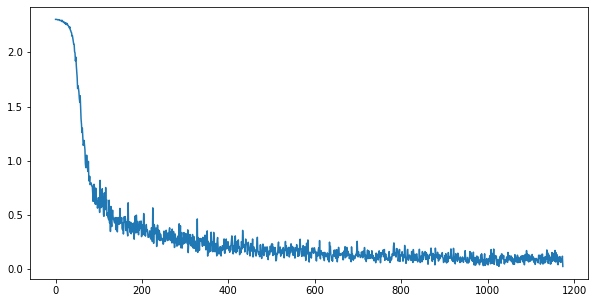

In [3]:
EPOCHS = 5
losses = []

model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        if cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        y_pred = model(data) 
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().data.item())
        loss.backward()
        optimizer.step()
        
        
        if batch_idx % 10 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.cpu().data.item()), 
                end='')

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader.dataset), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().data.item(),
        accuracy,
        end=''))
pylab.rcParams['figure.figsize'] = (10,5)
plot(losses)

# 4. Sample inputs and check attention map

In [0]:
# retrieve a minibatch and outputs
 with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            output, at1 = model(data, ret_attn=True)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            break


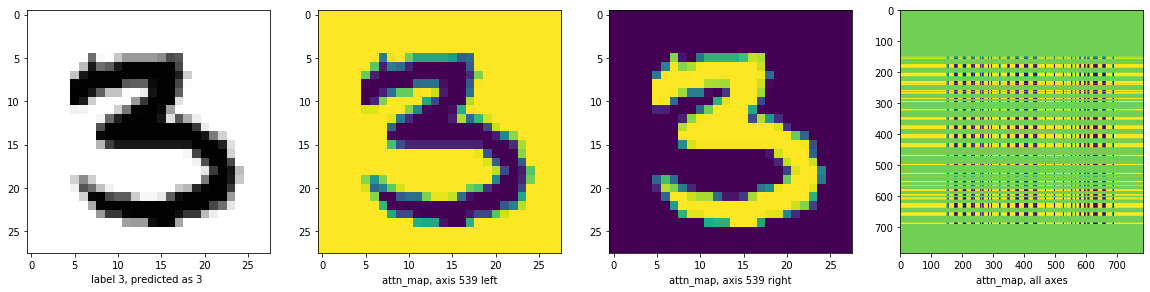

In [9]:
pylab.rcParams['figure.figsize'] = (20, 20)
i = random.randint(0,data.size(0))
label = target.cpu()[i]
predicted = pred.cpu()[i].item()
pixels = data.cpu()[i].numpy().reshape((28, 28))

attn_map = at1.cpu()[i].numpy() # 784 x 784, self-attended 784 pixels
attn_ax = random.randint(0,784) # sample any single line from attn_map
fig, (p1, p2, p3, p4) = plt.subplots(1,4)
p1.set_xlabel('label {}, predicted as {} '.format(label, predicted))
p1.imshow(-pixels, cmap='gray') # negative for black outline
p2.set_xlabel('attn_map, axis {} left'.format(attn_ax))
p2.imshow(attn_map[attn_ax, :].reshape((28, 28)), cmap='viridis')
p3.set_xlabel('attn_map, axis {} right'.format(attn_ax))
p3.imshow(attn_map[:, attn_ax].reshape((28, 28)), cmap='viridis')
p4.set_xlabel('attn_map, all axes')
p4.imshow(attn_map, cmap='viridis')

fig.show()

# 5. Save

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# path = F"/content/gdrive/My Drive/mnist-attn.pt" 
# torch.save(model, path) 
# model = torch.load(path) # check if it is working
# print(model)